In [3]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from ultralytics import YOLO
import shutil
from tqdm import tqdm
import yaml
import random
from PIL import Image
import torch
import zipfile

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Data Preparation

In [5]:
zipref = zipfile.ZipFile("/content/drive/MyDrive/YOLO/train.zip", 'r')
zipref.extractall("/content/YOLO")
zipref.close()

In [6]:
roots = '/content/YOLO'

In [7]:
yolo_dataset_root = os.path.join(roots, 'yolo_formatted_dataset')
os.makedirs(yolo_dataset_root, exist_ok=True)

In [8]:
yolo_train_images_dir = os.path.join(yolo_dataset_root, 'images', 'train')
yolo_val_images_dir = os.path.join(yolo_dataset_root, 'images', 'val')
yolo_train_labels_dir = os.path.join(yolo_dataset_root, 'labels', 'train')
yolo_val_labels_dir = os.path.join(yolo_dataset_root, 'labels', 'val')

os.makedirs(yolo_train_images_dir, exist_ok=True)
os.makedirs(yolo_val_images_dir, exist_ok=True)
os.makedirs(yolo_train_labels_dir, exist_ok=True)
os.makedirs(yolo_val_labels_dir, exist_ok=True)

In [9]:
class_names = ['Organik', 'Anorganik']
class_to_id = {name: i for i, name in enumerate(class_names)}
id_to_class = {i: name for i, name in enumerate(class_names)}

print(f"Nama kelas yang terdeteksi: {class_names}")
print(f"Mapping kelas ke ID: {class_to_id}")

Nama kelas yang terdeteksi: ['Organik', 'Anorganik']
Mapping kelas ke ID: {'Organik': 0, 'Anorganik': 1}


In [10]:
all_image_paths = []
all_label_paths = []
for category in ['organik', 'anorganik']:
    category_images_dir = os.path.join(roots, 'train', category)
    category_labels_dir = os.path.join(roots, 'train', category, 'labels')

    if not os.path.exists(category_images_dir) or not os.path.exists(category_labels_dir):
        print(f"Peringatan: Folder '{category_images_dir}' atau '{category_labels_dir}' tidak ditemukan. Melewatkan kategori ini.")
        continue

    for img_name in os.listdir(category_images_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(category_images_dir, img_name)

            # Ganti ekstensi gambar dengan .txt untuk mendapatkan nama file label yang diharapkan
            label_name = os.path.splitext(img_name)[0] + '.txt'
            label_path = os.path.join(category_labels_dir, label_name)

            if os.path.exists(label_path):
                all_image_paths.append(image_path)
                all_label_paths.append(label_path)
            else:
                print(f"Peringatan: Label tidak ditemukan untuk gambar {image_path}. Melewatkan pasangan ini.")

print(f"\nTotal pasangan gambar-label yang ditemukan: {len(all_image_paths)}")


Total pasangan gambar-label yang ditemukan: 4183


In [11]:
data_pairs = list(zip(all_image_paths, all_label_paths))

random.shuffle(data_pairs)

### Split Data

In [12]:
train_ratio = 0.8
split_index = int(len(data_pairs) * train_ratio)

train_data = data_pairs[:split_index]
val_data = data_pairs[split_index:]

print(f"Jumlah data pelatihan: {len(train_data)}")
print(f"Jumlah data validasi: {len(val_data)}")

Jumlah data pelatihan: 3346
Jumlah data validasi: 837


In [13]:
# Salin file ke struktur YOLOv8
print("\nMenyalin file ke folder pelatihan...")
for original_img_path, original_label_path in tqdm(train_data, desc="Memproses data train"):
    img_name = os.path.basename(original_img_path)
    label_name = os.path.basename(original_label_path)

    shutil.copy(original_img_path, os.path.join(yolo_train_images_dir, img_name))
    shutil.copy(original_label_path, os.path.join(yolo_train_labels_dir, label_name))

print("\nMenyalin file ke folder validasi...")
for original_img_path, original_label_path in tqdm(val_data, desc="Memproses data val"):
    img_name = os.path.basename(original_img_path)
    label_name = os.path.basename(original_label_path)

    shutil.copy(original_img_path, os.path.join(yolo_val_images_dir, img_name))
    shutil.copy(original_label_path, os.path.join(yolo_val_labels_dir, label_name))

print("\nPenyalinan dataset selesai!")


Menyalin file ke folder pelatihan...


Memproses data train: 100%|██████████| 3346/3346 [00:03<00:00, 884.33it/s] 



Menyalin file ke folder validasi...


Memproses data val: 100%|██████████| 837/837 [00:00<00:00, 848.30it/s] 


Penyalinan dataset selesai!


In [14]:
classes_file_path = os.path.join(yolo_dataset_root, 'classes.txt')
with open(classes_file_path, 'w') as f:
    for cls_name in class_names:
        f.write(f"{cls_name}\n")
print(f"File classes.txt berhasil dibuat di {classes_file_path}")

File classes.txt berhasil dibuat di /content/YOLO/yolo_formatted_dataset/classes.txt


## Konfigurasi data

In [15]:
yolo_dataset_root = os.path.join(roots, 'yolo_formatted_dataset')

In [16]:
with open(os.path.join(yolo_dataset_root, 'classes.txt'), 'r') as f:
    names = [line.strip() for line in f.readlines()]

nc = len(names)

In [17]:
data_config = {
    'path': yolo_dataset_root,
    'train': 'images/train',
    'val': 'images/val',
    'nc': nc,
    'names': names
}

In [18]:
# Simpan konfigurasi ke file data.yaml
data_yaml_path = os.path.join(yolo_dataset_root, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

print(f"File konfigurasi dataset '{data_yaml_path}' berhasil dibuat.")
print("Isi file data.yaml:")
with open(data_yaml_path, 'r') as f:
    print(f.read())

File konfigurasi dataset '/content/YOLO/yolo_formatted_dataset/data.yaml' berhasil dibuat.
Isi file data.yaml:
path: /content/YOLO/yolo_formatted_dataset
train: images/train
val: images/val
nc: 2
names:
- Organik
- Anorganik



## Modeling

In [19]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 104MB/s]


In [20]:
data_yaml_path = os.path.join(yolo_dataset_root, 'data.yaml')

In [21]:
print(f"Apakah CUDA tersedia: {torch.cuda.is_available()}")
device = '0' if torch.cuda.is_available() else 'cpu'
print(f"Menggunakan perangkat: {device}")

Apakah CUDA tersedia: True
Menggunakan perangkat: 0


In [22]:
# Latih model
results = model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov8_waste+',
    device=device,
)

print("\nPelatihan selesai!")
print(f"Bobot model terbaik disimpan di: {model.trainer.save_dir}/weights/best.pt")

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/YOLO/yolo_formatted_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_waste+, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751702  ultralytics.nn.modules.head.Detect           [2, [64, 128, 256]]           
Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 81.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.2 ms, read: 1711.1±1122.5 MB/s, size: 387.5 KB)


train: Scanning /content/YOLO/yolo_formatted_dataset/labels/train... 3344 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3344/3344 [00:01<00:00, 2374.66it/s]

train: /content/YOLO/yolo_formatted_dataset/images/train/3d3ddc3054b32eb7.jpg: 1 duplicate labels removed
train: New cache created: /content/YOLO/yolo_formatted_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 566.9±264.3 MB/s, size: 399.0 KB)


val: Scanning /content/YOLO/yolo_formatted_dataset/labels/val... 837 images, 0 backgrounds, 0 corrupt: 100%|██████████| 837/837 [00:00<00:00, 1258.63it/s]

val: New cache created: /content/YOLO/yolo_formatted_dataset/labels/val.cache


Plotting labels to runs/detect/yolov8_waste+/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_waste+
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.84G      1.271      2.246      1.393        101        640: 100%|██████████| 209/209 [01:19<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:12<00:00,  2.13it/s]


                   all        837       2882      0.358      0.367      0.265       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.55G      1.389      2.065      1.486        147        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]


                   all        837       2882      0.341      0.352      0.266      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.56G      1.435      2.042      1.516        118        640: 100%|██████████| 209/209 [01:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


                   all        837       2882      0.298      0.329      0.237      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.58G      1.452      2.024      1.545         75        640: 100%|██████████| 209/209 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


                   all        837       2882      0.346      0.383      0.283      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       3.6G      1.419      1.949      1.511        237        640: 100%|██████████| 209/209 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.60it/s]


                   all        837       2882      0.378      0.387      0.319      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       3.9G      1.393      1.908      1.493         89        640: 100%|██████████| 209/209 [01:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.66it/s]


                   all        837       2882      0.341      0.348       0.26      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.92G      1.351      1.833      1.468        147        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]


                   all        837       2882      0.377      0.382      0.296      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.93G      1.347      1.807      1.462         79        640: 100%|██████████| 209/209 [01:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


                   all        837       2882      0.434      0.417      0.368      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.23G      1.338      1.788      1.452         85        640: 100%|██████████| 209/209 [01:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.56it/s]


                   all        837       2882      0.478       0.43      0.392      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.25G      1.312      1.744      1.449         85        640: 100%|██████████| 209/209 [01:12<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


                   all        837       2882      0.457      0.425      0.401      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.27G      1.307      1.708      1.443        110        640: 100%|██████████| 209/209 [01:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


                   all        837       2882      0.448      0.423       0.38      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.29G      1.269      1.674      1.425         80        640: 100%|██████████| 209/209 [01:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.53it/s]


                   all        837       2882      0.456      0.424      0.377      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.3G      1.261      1.621      1.405        130        640: 100%|██████████| 209/209 [01:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.71it/s]


                   all        837       2882      0.441       0.46        0.4      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.32G      1.259      1.624      1.411        173        640: 100%|██████████| 209/209 [01:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


                   all        837       2882      0.474      0.475      0.431      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.34G      1.255      1.602        1.4         90        640: 100%|██████████| 209/209 [01:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


                   all        837       2882      0.491      0.475       0.45      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.35G      1.226      1.571      1.389         88        640: 100%|██████████| 209/209 [01:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.62it/s]


                   all        837       2882      0.482      0.496      0.468      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.37G      1.218      1.559      1.375        123        640: 100%|██████████| 209/209 [01:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]


                   all        837       2882      0.457      0.494      0.425      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.39G      1.217      1.548      1.378         73        640: 100%|██████████| 209/209 [01:13<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.51it/s]


                   all        837       2882      0.521      0.471       0.46      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       4.4G      1.214      1.541      1.369         98        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]


                   all        837       2882      0.498      0.477       0.45       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.42G      1.194      1.501      1.356         85        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


                   all        837       2882      0.507      0.492      0.445      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.44G      1.192      1.495      1.354         63        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.49it/s]


                   all        837       2882      0.493      0.501      0.455      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.46G      1.196      1.479      1.342        103        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.51it/s]


                   all        837       2882      0.534       0.49       0.48      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.47G      1.172      1.434      1.344        132        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.45it/s]


                   all        837       2882      0.477      0.489      0.435      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.78G      1.173      1.438      1.338        102        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.62it/s]


                   all        837       2882      0.512      0.525       0.49      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.17G      1.169       1.41      1.335        120        640: 100%|██████████| 209/209 [01:14<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]


                   all        837       2882      0.522      0.484      0.473      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.18G      1.151      1.406       1.32        131        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.90it/s]


                   all        837       2882       0.56        0.5      0.499      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       5.2G      1.153      1.382      1.322         77        640: 100%|██████████| 209/209 [01:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


                   all        837       2882      0.535      0.499      0.488      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.22G      1.142       1.36      1.315         83        640: 100%|██████████| 209/209 [01:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.51it/s]


                   all        837       2882      0.533      0.517       0.51      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.23G      1.148      1.355      1.319        159        640: 100%|██████████| 209/209 [01:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.46it/s]


                   all        837       2882      0.526       0.48       0.46      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.25G      1.135      1.349      1.316        133        640: 100%|██████████| 209/209 [01:14<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]


                   all        837       2882      0.566      0.505      0.505      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.27G      1.121      1.319       1.29         78        640: 100%|██████████| 209/209 [01:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.49it/s]

                   all        837       2882      0.553      0.524       0.51      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.29G      1.123      1.319      1.296         94        640: 100%|██████████| 209/209 [01:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.54it/s]


                   all        837       2882      0.538      0.531      0.501      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       5.3G      1.106      1.275      1.291         92        640: 100%|██████████| 209/209 [01:12<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.50it/s]


                   all        837       2882      0.571      0.494      0.487      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.32G      1.109      1.289      1.295         93        640: 100%|██████████| 209/209 [01:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


                   all        837       2882      0.547      0.509      0.485      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.34G      1.087      1.285      1.286         84        640: 100%|██████████| 209/209 [01:13<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


                   all        837       2882      0.544      0.536      0.514      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.35G      1.081      1.249      1.279        106        640: 100%|██████████| 209/209 [01:12<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


                   all        837       2882      0.549      0.543      0.514      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.37G      1.092      1.243      1.275         88        640: 100%|██████████| 209/209 [01:12<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.48it/s]


                   all        837       2882      0.562      0.526      0.508      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.39G       1.07      1.221      1.274         82        640: 100%|██████████| 209/209 [01:12<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.45it/s]


                   all        837       2882      0.576       0.51      0.508       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       5.4G      1.057      1.191      1.261        114        640: 100%|██████████| 209/209 [01:13<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.60it/s]

                   all        837       2882      0.554      0.521      0.499       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.42G       1.07      1.179      1.262        102        640: 100%|██████████| 209/209 [01:12<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.67it/s]

                   all        837       2882      0.556      0.547      0.526      0.348


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.44G      1.074      1.203       1.27         35        640: 100%|██████████| 209/209 [01:12<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


                   all        837       2882      0.542      0.531      0.502      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.46G      1.055      1.124      1.266         62        640: 100%|██████████| 209/209 [01:10<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.56it/s]

                   all        837       2882      0.546       0.53      0.504      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.47G      1.029      1.084      1.235         74        640: 100%|██████████| 209/209 [01:10<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.56it/s]


                   all        837       2882       0.58      0.507      0.516      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.49G      1.027      1.092      1.245         72        640: 100%|██████████| 209/209 [01:10<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.95it/s]

                   all        837       2882      0.561      0.536      0.527       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.51G      1.023      1.057      1.243         73        640: 100%|██████████| 209/209 [01:10<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.56it/s]


                   all        837       2882      0.571      0.543      0.523      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.53G      1.011      1.049      1.237         25        640: 100%|██████████| 209/209 [01:10<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.54it/s]


                   all        837       2882       0.56       0.55      0.519      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.54G      1.006      1.019       1.22         50        640: 100%|██████████| 209/209 [01:09<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.90it/s]

                   all        837       2882       0.57      0.545      0.524      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.56G     0.9955     0.9933      1.219         29        640: 100%|██████████| 209/209 [01:09<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.56it/s]


                   all        837       2882      0.593      0.522      0.522      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.58G     0.9922     0.9995      1.213         64        640: 100%|██████████| 209/209 [01:10<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


                   all        837       2882      0.555       0.54      0.516      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.59G     0.9815     0.9742      1.211         89        640: 100%|██████████| 209/209 [01:08<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.47it/s]


                   all        837       2882      0.567      0.535      0.523      0.348

50 epochs completed in 1.169 hours.
Optimizer stripped from runs/detect/yolov8_waste+/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8_waste+/weights/best.pt, 6.2MB

Validating runs/detect/yolov8_waste+/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


                   all        837       2882      0.561      0.536      0.527      0.349
               Organik        612       2308      0.537      0.458      0.463      0.294
             Anorganik        225        574      0.586      0.615      0.592      0.405
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/yolov8_waste+

Pelatihan selesai!
Bobot model terbaik disimpan di: runs/detect/yolov8_waste+/weights/best.pt


## Validasi Model

In [23]:
model_path = os.path.join(model.trainer.save_dir, 'weights', 'best.pt')
model = YOLO(model_path)

In [24]:
metrics = model.val(data=data_yaml_path, imgsz=640, batch=16)
print("\nHasil Validasi:")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"mAP75: {metrics.box.map75}")
print(f"Presisi: {metrics.box.p}")
print(f"Recall: {metrics.box.r}")

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2091.4±948.6 MB/s, size: 360.1 KB)


val: Scanning /content/YOLO/yolo_formatted_dataset/labels/val.cache... 837 images, 0 backgrounds, 0 corrupt: 100%|██████████| 837/837 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:11<00:00,  4.51it/s]


                   all        837       2882      0.559      0.537      0.527      0.349
               Organik        612       2308      0.535      0.458      0.464      0.294
             Anorganik        225        574      0.584      0.617       0.59      0.403
Speed: 0.6ms preprocess, 4.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val

Hasil Validasi:
mAP50-95: 0.3489154615990706
mAP50: 0.5265943859388929
mAP75: 0.3756335918687938
Presisi: [    0.53478     0.58352]
Recall: [    0.45822     0.61672]


### test prediksi pada gambar baru


image 1/1 /content/tst1.jpg: 448x640 1 Anorganik, 14.2ms
Speed: 8.0ms preprocess, 14.2ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)
Hasil prediksi disimpan di: predictions/test_image_prediction_0.jpg


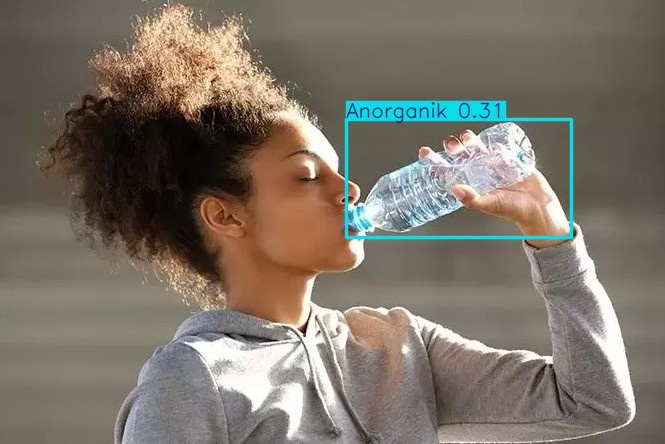


Deteksi untuk gambar /content/tst1.jpg:
  Objek: Anorganik, Kepercayaan: 0.31, Box: [346.352294921875, 119.64934539794922, 571.5789184570312, 237.9141082763672]


In [29]:
test_image_path = '/content/tst1.jpg'

if not os.path.exists(test_image_path):
    print(f"Error: Gambar uji tidak ditemukan di {test_image_path}")
    print("Pastikan Anda mengganti 'test_image_path' dengan path yang benar.")
else:

    results = model(test_image_path)
    from IPython.display import Image, display

    for i, r in enumerate(results):
        os.makedirs('predictions', exist_ok=True)
        plot_path = os.path.join('predictions', f'test_image_prediction_{i}.jpg')

        r.save(filename=plot_path)
        print(f"Hasil prediksi disimpan di: {plot_path}")
        display(Image(filename=plot_path))

        boxes = r.boxes.xyxy.tolist()
        confidences = r.boxes.conf.tolist()
        class_ids = r.boxes.cls.tolist()

        print(f"\nDeteksi untuk gambar {test_image_path}:")
        for j in range(len(boxes)):
            class_name = model.names[int(class_ids[j])]
            print(f"  Objek: {class_name}, Kepercayaan: {confidences[j]:.2f}, Box: {boxes[j]}")


## Save Models

In [30]:
export_path = model.export(format='onnx')

print(f"Model berhasil diekspor ke: {export_path}")

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/yolov8_waste+/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 5.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 7.9s, saved as 'runs/detect/yolov8_waste+/weights/best.onnx' (11.7 MB)

Export complete (8.3s)
Results saved to /content/runs/detect/yolov8_waste+/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8_waste+/weights/best.onnx imgsz=